# Camera Calibration Example

## Generate data

In [1]:
%cd ..

/mnt/d/CodingProjects/zodiacal-polarized


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy.optimize import least_squares
from scipy.ndimage import gaussian_filter

# import the necessary modules
from zodipol.utils.argparser import ArgParser
from zodipol.zodipol import Zodipol, Observation
from zodipol.visualization.skymap_plots import plot_satellite_image, plot_satellite_image_indices

In [3]:
parser = ArgParser(args=['-res', '300', '200', '--fov', '5', '-dir', '90', '40', '-par', '-ip', 'exposure_time', '10*u.s', '-nr', '50'])

In [4]:
zodipol = Zodipol(polarizance=parser["polarizance"], fov=parser["fov"], n_polarization_ang=parser["n_polarization_ang"], parallel=parser["parallel"], n_freq=parser["n_freq"], planetary=parser["planetry"], isl=parser["isl"], resolution=parser["resolution"], imager_params=parser["imager_params"])

In [ ]:
obs = zodipol.create_observation(theta=parser["direction"][0], phi=parser["direction"][1], lonlat=False, new_isl=parser["new_isl"])

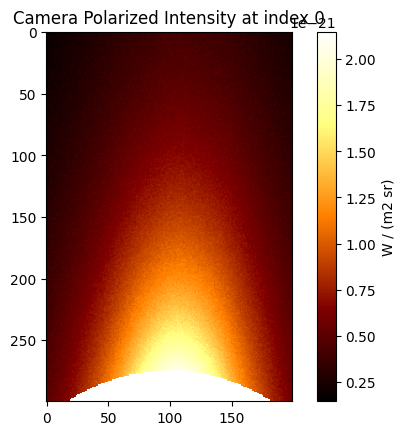

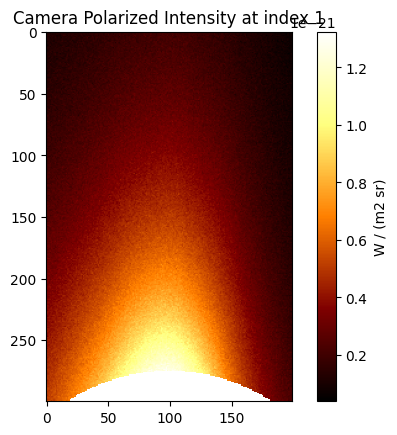

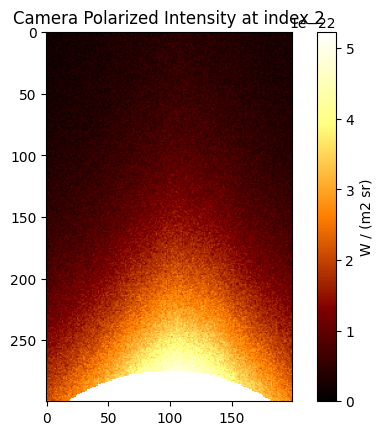

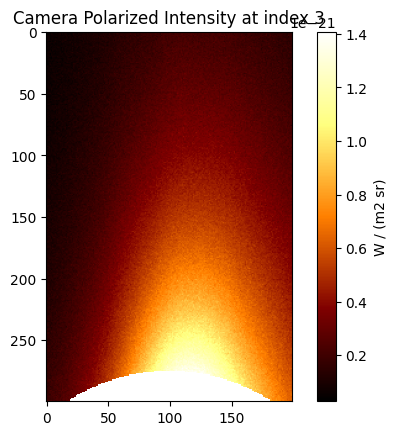

In [11]:
camera_intensity = zodipol.make_camera_images(obs, n_realizations=parser["n_realizations"], add_noise=True)
plot_satellite_image_indices(camera_intensity, 4, resolution=parser["resolution"], title="Camera Polarized Intensity")

## Camera polarizer angler calibration
Here we assume a constant polarizer angle shift, and calibrate the camera angle accordingly using a single projection

In [12]:
polarizance = parser["polarizance"]  # Polarizance of the observation
polarization_angle_diff = np.pi / parser["n_polarization_ang"]  # Polarization angle difference between the polarization angles

polarization_shift_list = np.linspace(0, np.pi, 10)
calibration_results = []
for polarization_shift in polarization_shift_list:
    polarization_angle = polarization_shift + parser["polarization_angle"]  # Polarization angle of the observation
    df_ind = polarization_angle_diff * np.arange(parser["n_polarization_ang"])
    make_img = lambda eta: zodipol.make_camera_images(obs, polarizance, eta+df_ind, n_realizations=parser["n_realizations"], fillna=0, add_noise=False)

    polarization_angle_res = []
    for ii in range(10):
        camera_intensity_real = zodipol.make_camera_images(obs, polarizance, polarization_angle, n_realizations=parser["n_realizations"], fillna=0, add_noise=True)
        cost_function = lambda eta: 1e23 * (make_img(eta) - camera_intensity_real).value.flatten()
        res = least_squares(cost_function, x0=0, bounds=(-np.pi/2, np.pi/2))
        polarization_angle_res.append(res.x)
    calibration_results.append(np.array(polarization_angle_res))
    print(f"Estimated polarization angle for eta={polarization_shift:.2f}: {np.mean(polarization_angle_res)%np.pi:.2f} +/- {np.std(polarization_angle_res):.2f} rad")
calibration_results = np.array(calibration_results).squeeze()

Estimated polarization angle for eta=0.00: 0.00 +/- 0.01 rad
Estimated polarization angle for eta=0.35: 0.35 +/- 0.01 rad
Estimated polarization angle for eta=0.70: 0.70 +/- 0.01 rad
Estimated polarization angle for eta=1.05: 1.05 +/- 0.01 rad
Estimated polarization angle for eta=1.40: 1.40 +/- 0.01 rad
Estimated polarization angle for eta=1.75: 1.75 +/- 0.00 rad
Estimated polarization angle for eta=2.09: 2.09 +/- 0.01 rad
Estimated polarization angle for eta=2.44: 2.45 +/- 0.01 rad
Estimated polarization angle for eta=2.79: 2.79 +/- 0.01 rad
Estimated polarization angle for eta=3.14: 0.00 +/- 0.01 rad


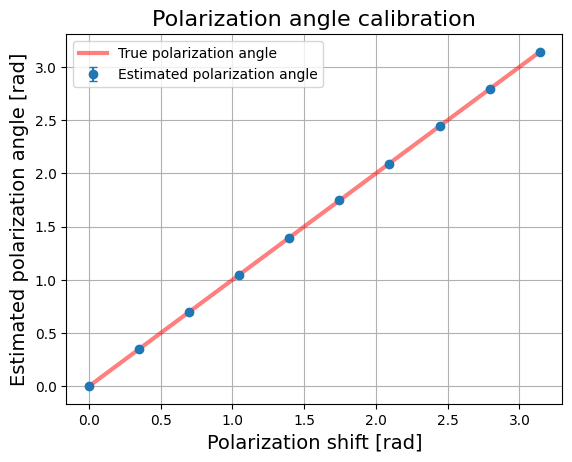

In [13]:
calib_mean = np.unwrap(calibration_results.mean(axis=1), period=np.pi)
calib_std = calibration_results.std(axis=1)

plt.figure()
plt.errorbar(polarization_shift_list, calib_mean, yerr=calib_std, fmt='o', capsize=3, label="Estimated polarization angle")
plt.plot(polarization_shift_list, polarization_shift_list, c='r', alpha=0.5, lw=3, label="True polarization angle")
plt.xlabel("Polarization shift [rad]", fontsize=14)
plt.ylabel("Estimated polarization angle [rad]", fontsize=14)
plt.title("Polarization angle calibration", fontsize=16)
plt.grid()
plt.legend()
plt.show()

## Camera polarizance calibration
Here we assume a constant polarizance issues, and calibrate the camera angle accordingly using a singe projection.

In [14]:
polarization_angle = 0.1  # Polarization angle of the observation
polarization_angle_diff = np.pi / parser["n_polarization_ang"]  # Polarization angle difference between the polarization angles

In [15]:
polarizance_list = np.linspace(0.5, 1, 10)  # Polarizance of the observation
calibration_results = []
for polarizance in polarizance_list:
    df_ind = polarization_angle_diff * np.arange(parser["n_polarization_ang"])
    make_img = lambda p: zodipol.make_camera_images(obs, p, polarization_angle+df_ind, n_realizations=parser["n_realizations"], fillna=0, add_noise=False)

    polarization_angle_res = []
    for ii in range(10):
        camera_intensity_real = zodipol.make_camera_images(obs, polarizance, polarization_angle+df_ind, n_realizations=parser["n_realizations"], fillna=0, add_noise=True)
        cost_function = lambda p: 1e23*(make_img(p) - camera_intensity_real).value.flatten()
        res = least_squares(cost_function, x0=0.5, bounds=(0, 1), diff_step=10)
        polarization_angle_res.append(res.x)
    calibration_results.append(np.array(polarization_angle_res))
    print(f"Estimated Polarizance for P={polarizance:.2f}: {np.mean(polarization_angle_res):.2f} +/- {np.std(polarization_angle_res):.2f}")
calibration_results = np.array(calibration_results).squeeze()

Estimated Polarizance for P=0.50: 0.50 +/- 0.00
Estimated Polarizance for P=0.56: 0.56 +/- 0.00
Estimated Polarizance for P=0.61: 0.61 +/- 0.00
Estimated Polarizance for P=0.67: 0.67 +/- 0.00
Estimated Polarizance for P=0.72: 0.72 +/- 0.00
Estimated Polarizance for P=0.78: 0.78 +/- 0.00
Estimated Polarizance for P=0.83: 0.83 +/- 0.00
Estimated Polarizance for P=0.89: 0.89 +/- 0.00
Estimated Polarizance for P=0.94: 0.94 +/- 0.00
Estimated Polarizance for P=1.00: 1.00 +/- 0.00


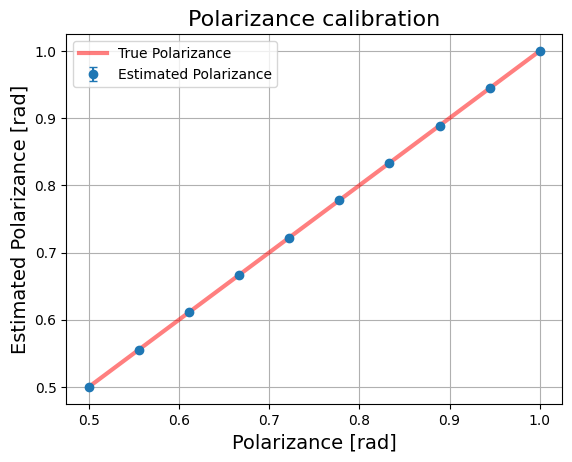

In [16]:
calib_mean = calibration_results.mean(axis=1)
calib_std = calibration_results.std(axis=1)

plt.figure()
plt.errorbar(polarizance_list, calib_mean, yerr=calib_std, fmt='o', capsize=3, label="Estimated Polarizance")
plt.plot(polarizance_list, polarizance_list, c='r', alpha=0.5, lw=3, label="True Polarizance")
plt.xlabel("Polarizance [rad]", fontsize=14)
plt.ylabel("Estimated Polarizance [rad]", fontsize=14)
plt.title("Polarizance calibration", fontsize=16)
plt.grid()
plt.legend()
plt.show()

## Camera Per-Pixel calibration
Here we take multiple observations of the same scene with rotations. We then use the camera images to calibrate the per-pixel polarization angles and polarizances.

In [5]:
n_rotations = 12
obs = [zodipol.create_observation(theta=parser["direction"][0], phi=parser["direction"][1], roll=t * u.deg, lonlat=False,
                                     new_isl=parser["new_isl"]) for t in np.linspace(0, 360, n_rotations, endpoint=False)]

/mnt/d/CodingProjects/zodiacal-polarized/zodipol/zodipy_local/zodipy_local/_source_funcs.py:28: RuntimeWarning: overflow encountered in expm1
  term2 = np.expm1((h * freq) / (k_B * T))


In [6]:
# Polarizance calibration example
polarizance, _ = np.meshgrid(np.linspace(0.8, 0.9, parser["resolution"][0]), np.arange(parser["resolution"][1]),
                   indexing='ij')
polarizance = polarizance.reshape((len(obs[0]), 1, 1))
obs_orig = [zodipol.make_camera_images(o, polarizance, parser["polarization_angle"],
                                       n_realizations=parser["n_realizations"], add_noise=True) for o in obs]
images_orig = np.stack(obs_orig, axis=-1)

In [7]:
# perform grid search for the polarizance
p_t = np.linspace(0.6, 1, 20)
img = [np.stack([zodipol.make_camera_images(o, p, parser["polarization_angle"], n_realizations=1, add_noise=False) for p in p_t], axis=-1) for o in obs]
img_stack = np.stack(img, axis=-2)
diff_resh = (img_stack - images_orig[..., None]).value.reshape(parser["resolution"] + [parser["n_polarization_ang"], n_rotations, len(p_t)])

c = np.nansum((1e23 * diff_resh) ** 2, axis=(-3, -2))
p_est = p_t[np.argmin(np.nan_to_num(c, nan=np.inf), axis=-1)]

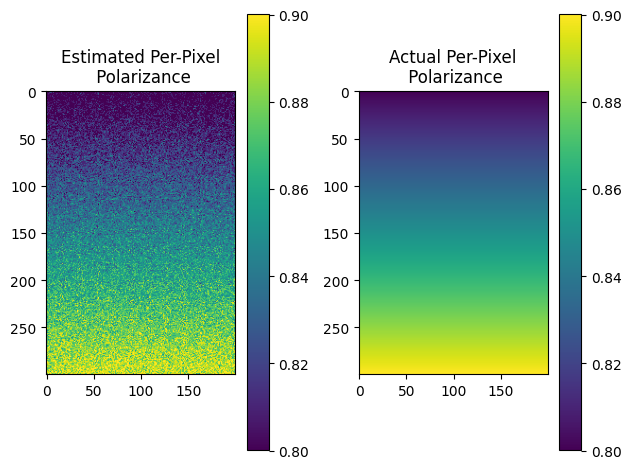

In [25]:
# Compare the per-pixel polarizance and estimated polarizance
fig, (ax1, ax2) = plt.subplots(1, 2)
c1 = ax1.imshow(p_est)
c1.set_clim(0.8, 0.9)
plt.colorbar(c1, ax=ax1)
ax1.set_title('Estimated Per-Pixel\n Polarizance')
c2 = ax2.imshow(polarizance.reshape(parser["resolution"]))
c2.set_clim(0.8, 0.9)
plt.colorbar(c2, ax=ax2)
ax2.set_title('Actual Per-Pixel\n Polarizance')
fig.tight_layout()
plt.savefig('outputs/polarizance_estimation.pdf')
plt.show()

Now doing the same for the per-pixel angle of polarization.

In [5]:
n_rotations = 12
obs = [zodipol.create_observation(theta=parser["direction"][0], phi=parser["direction"][1], roll=t * u.deg, lonlat=False, new_isl=parser["new_isl"]) for t in np.linspace(0, 360, n_rotations, endpoint=False)]

/mnt/d/CodingProjects/zodiacal-polarized/zodipol/zodipy_local/zodipy_local/_source_funcs.py:28: RuntimeWarning: overflow encountered in expm1
  term2 = np.expm1((h * freq) / (k_B * T))


In [110]:
polarization_angle = np.linspace(0, np.pi, 4, endpoint=False)
polarization_angle_spatial_diff, _ = np.meshgrid(np.deg2rad(np.linspace(-10, 10, parser["resolution"][0])), np.arange(parser["resolution"][1]), indexing='ij')
polarization_angle_real = polarization_angle[None, None :] + polarization_angle_spatial_diff.flatten()[:, None, None]

In [111]:
# Polarizance calibration example
polarizance = 1

obs_orig = [zodipol.make_camera_images(o, polarizance, polarization_angle_real,
                                       n_realizations=parser["n_realizations"], add_noise=True) for o in obs]
images_orig = np.stack(obs_orig, axis=-1)

In [112]:
# perform grid search for the polarizance
p_t = np.deg2rad(np.linspace(-45, 45, 20))
img = [np.stack([zodipol.make_camera_images(o, polarizance, polarization_angle+p, n_realizations=1, add_noise=False) for p in p_t], axis=-1) for o in obs]
img_stack = np.stack(img, axis=-1)
diff_resh = (img_stack - images_orig[..., None, :]).value.reshape(tuple(parser["resolution"]) + img_stack.shape[1:])

c = np.nansum((1e21 * diff_resh) ** 2, axis=(-3, -1))
p_est = p_t[np.argmin(np.nan_to_num(c, nan=np.inf), axis=-1)]

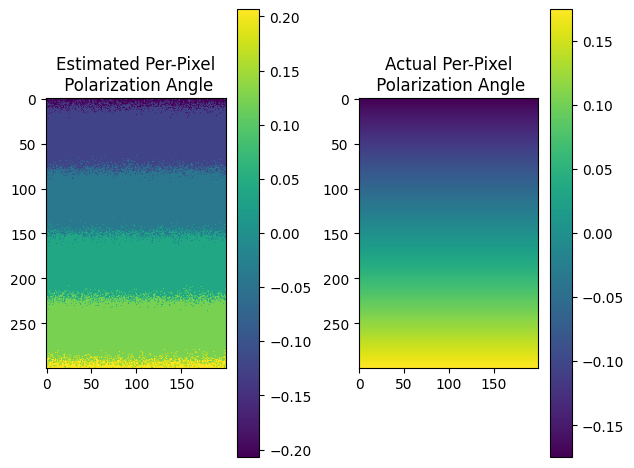

In [114]:
# Compare the per-pixel polarizance and estimated polarizance
fig, (ax1, ax2) = plt.subplots(1, 2)
c1 = ax1.imshow(p_est)
# c1.set_clim(-np.pi * 30  / 180, np.pi * 30  / 180)
plt.colorbar(c1, ax=ax1)
ax1.set_title('Estimated Per-Pixel\n Polarization Angle')
c2 = ax2.imshow(polarization_angle_spatial_diff)
# c2.set_clim(-np.pi * 30  / 180, np.pi * 30  / 180)
plt.colorbar(c2, ax=ax2)
ax2.set_title('Actual Per-Pixel\n Polarization Angle')
fig.tight_layout()
plt.savefig('outputs/polarization_angle_estimation.pdf')
plt.show()

## Calibrate birefringence

### Birefringence matrix example

In [5]:
biref_amount = zodipol.imager.get_birefringence_mat(0.3, 'center', flat=True, std=3, inv=True)
biref_angle = zodipol.imager.get_birefringence_mat(np.pi/4, 'constant', flat=True)
biref_mueller = zodipol.imager.get_birefringence_mueller_matrix(biref_amount, biref_angle)

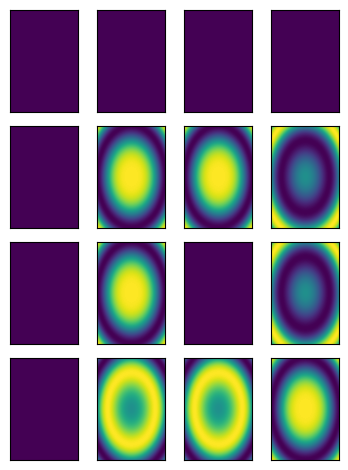

In [54]:
fig, ax = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(biref_mueller[:, i, j].reshape(parser["resolution"]))
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
plt.tight_layout(w_pad=-15.0, h_pad=1.0)
plt.show()

### Birefringence calibration - unnoised

In [14]:
def make_biref_img(obs, delta, phi, add_noise=False, n_realizations=1, **kwargs):
    biref_mueller = zodipol.imager.get_birefringence_mueller_matrix(delta, phi)
    biref_obs = zodipol.imager.apply_birefringence(obs, biref_mueller)
    if add_noise:
        biref_camera_intensity = zodipol.make_camera_images(biref_obs, parser["polarizance"], parser["polarization_angle"], n_realizations=n_realizations, add_noise=add_noise, **kwargs)
    else:
        biref_camera_intensity = zodipol.make_camera_images(biref_obs, parser["polarizance"], parser["polarization_angle"], n_realizations=1, add_noise=add_noise, **kwargs)
    return biref_camera_intensity

In [17]:
# Create observations
n_rotations = 6
obs = [zodipol.create_observation(theta=parser["direction"][0], phi=parser["direction"][1], roll=t * u.deg, lonlat=False, new_isl=parser["new_isl"]) for t in np.linspace(0, 360, n_rotations, endpoint=False)]

/mnt/d/CodingProjects/zodiacal-polarized/zodipol/zodipy_local/zodipy_local/_source_funcs.py:28: RuntimeWarning: overflow encountered in expm1
  term2 = np.expm1((h * freq) / (k_B * T))


Estimate $\delta$ of birefringence using grid search

In [40]:
delta_val, phi_val = np.pi/2, 0
delta = zodipol.imager.get_birefringence_mat(delta_val, 'constant', flat=True)
phi = zodipol.imager.get_birefringence_mat(phi_val, 'constant', flat=True)
biref_camera_intensity = [make_biref_img(o, delta, phi, n_realizations=parser["n_realizations"], fillna=0, add_noise=True) for o in obs]
biref_camera_intensity_stack = np.stack(biref_camera_intensity, axis=-1)

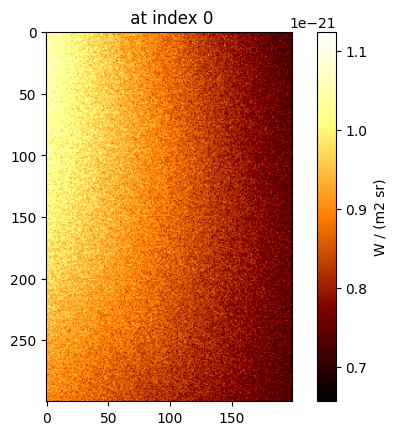

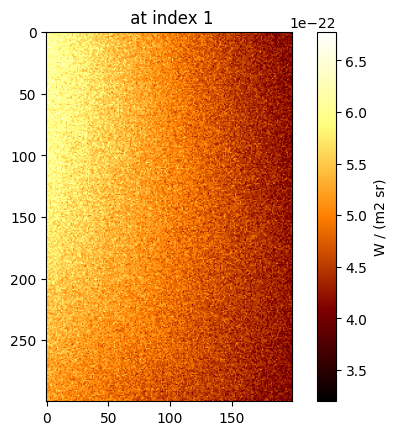

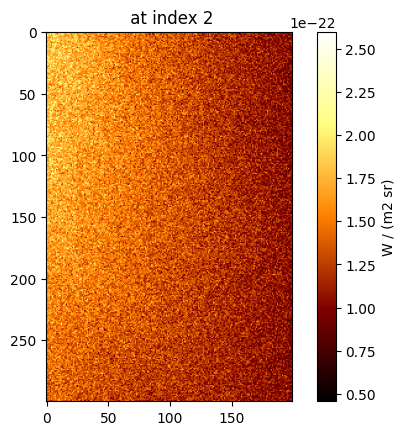

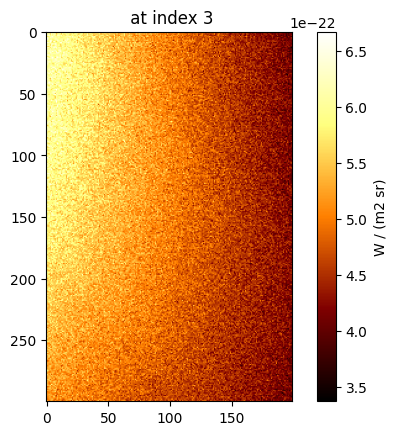

In [65]:
plot_satellite_image_indices(biref_camera_intensity_stack[..., 4], 4, resolution=parser["resolution"])

In [20]:
d_t = np.linspace(-np.pi/2, np.pi/2, 20)
img = [np.stack([make_biref_img(o, d, phi, n_realizations=1, add_noise=False) for d in d_t], axis=-1) for o in obs]
img_stack = np.stack(img, axis=-1)
diff_resh = (img_stack - biref_camera_intensity_stack[..., None, :]).value.reshape(tuple(parser["resolution"]) + img_stack.shape[1:])

c = np.nansum((1e21 * diff_resh) ** 2, axis=(-3, -1))
d_est = d_t[np.argmin(np.nan_to_num(c, nan=np.inf), axis=-1)]

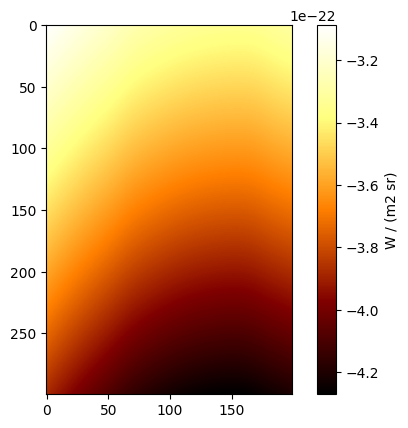

In [76]:
plot_satellite_image(img_stack[..., 1, 0, 0] - img_stack[..., 0, 0, 0], resolution=parser["resolution"])

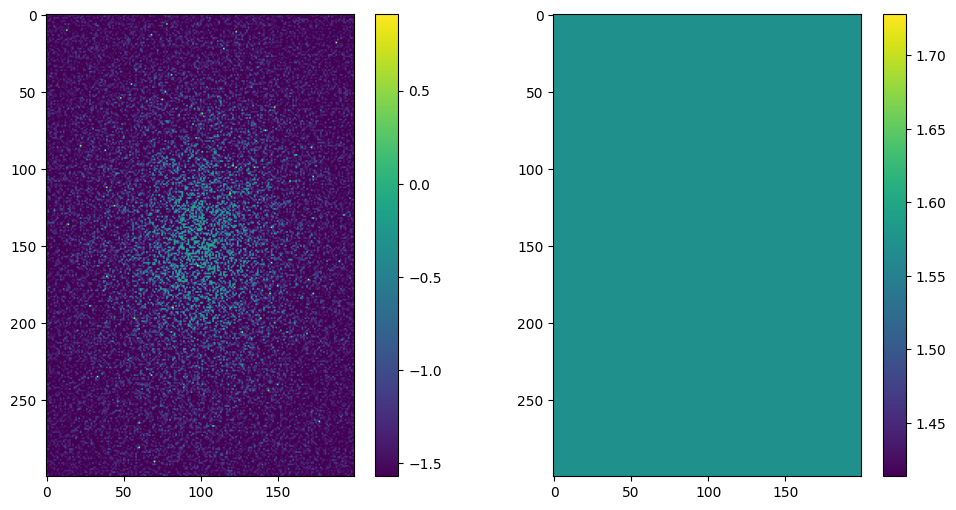

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
c1 = ax1.imshow(d_est)
plt.colorbar(c1, ax=ax1)
c2 = ax2.imshow(delta.reshape(parser["resolution"]))
plt.colorbar(c2, ax=ax2)
plt.show()

### Birefringence calibration - noised

In [99]:
delta, phi = 1, 0
delta_m = zodipol.imager._get_birefringence_mat(delta, 'center', flat=True, std=3)
phi_m = zodipol.imager._get_birefringence_mat(phi, 'constant', flat=True)
biref_camera_intensity = make_biref_img(delta_m, phi_m, fillna=0, add_noise=True)

In [101]:
delta_t = np.linspace(0, np.pi, 20)
biref_camera_intensity_t = np.stack([make_biref_img(d, phi_m, fillna=0, add_noise=False) for d in delta_t], axis=-1)

c = ((1e23 * (biref_camera_intensity_t - biref_camera_intensity[..., None]).value) ** 2).sum(axis=1)

delta_est = delta_t[c.argmin(axis=1)]

dd = (delta_m - delta_est) / (delta_m + 1e-10)

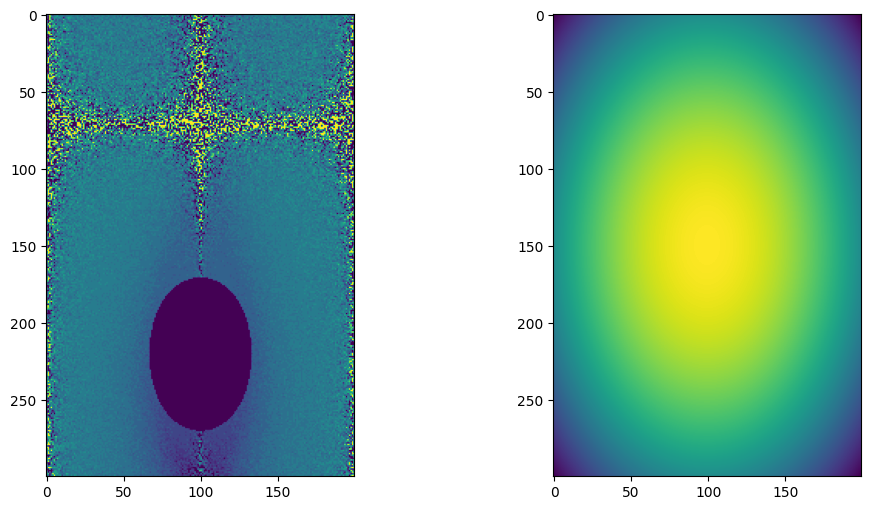

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(delta_est.reshape(parser["resolution"]))
ax2.imshow(delta_m.reshape(parser["resolution"]))
plt.show()

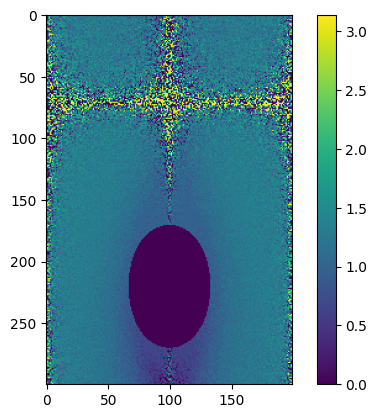

In [103]:
plt.figure()
plt.imshow(delta_est.reshape(parser["resolution"]))
plt.colorbar()
plt.show()

In [ ]:
delta, phi = 1, 0
delta_m = zodipol.imager._get_birefringence_mat(delta, 'center', flat=True, std=3)
phi_m = zodipol.imager._get_birefringence_mat(phi, 'constant', flat=True)
biref_camera_intensity = make_biref_img(delta_m, phi_m, fillna=0, add_noise=True)

delta_t = np.linspace(0, np.pi, 10)
biref_camera_intensity_t = np.stack([make_biref_img(d, phi_m, fillna=0, add_noise=False) for d in delta_t], axis=-1)

from scipy.ndimage import gaussian_filter
diff_resh = (biref_camera_intensity_t - biref_camera_intensity[..., None]).value.reshape(parser["resolution"] + [4, 10])
gg = gaussian_filter(diff_resh, (10, 10, 0, 0), mode='nearest')

c = ((1e23 * gg) ** 2).sum(axis=-2)
delta_est = delta_t[c.argmin(axis=-1)]
# dd = (delta_m - delta_est) / (delta_m + 1e-10)

plt.figure()
plt.imshow(delta_est.reshape(parser["resolution"]))
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(delta_m.reshape(parser["resolution"]))
plt.colorbar()
plt.show()